In [ ]:
import tensorflow as tf
print(tf.__version__)
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()

2.7.0


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# **단계 1**

In [ ]:
from keras import layers 
from keras import models
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from keras.utils.vis_utils import plot_model
# 8주차 첨부파일인 5_1_introduction_to_convnets_202109.ipynb 모델과는 달리 제가 만든 모델은 conv2D,conv2D,MaxPooling2D로 해보았습니다. 또한 dense를 64에서 32로 파라메터를 줄여서 파라메터의 갯수가 
# 65600 개에서 32800로 절반가까이 줄어 드렀습니다.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',name = 'check'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax', name = 'last'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 check (Conv2D)              (None, 10, 10, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                    

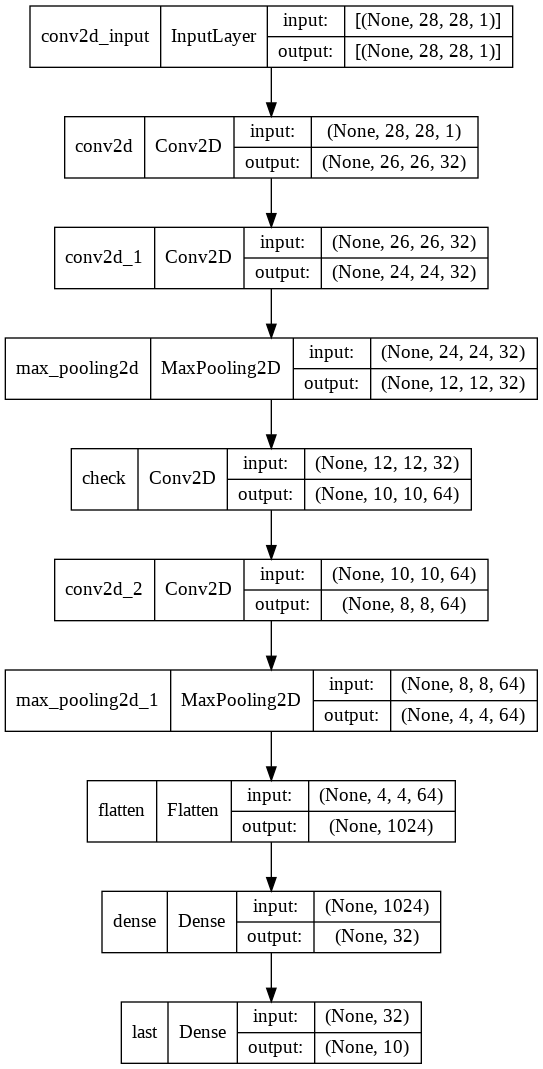

In [ ]:
plot_model( model, show_shapes= True)

In [ ]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 183us/sample - loss: 0.1474 - accuracy: 0.9535
Epoch 2/5
60000/60000 [==============================] - 9s 155us/sample - loss: 0.0426 - accuracy: 0.9870
Epoch 3/5
60000/60000 [==============================] - 9s 157us/sample - loss: 0.0304 - accuracy: 0.9905
Epoch 4/5
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0235 - accuracy: 0.9931
Epoch 5/5
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0191 - accuracy: 0.9944


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

0.9905

# **단계 2**

<IPython.core.display.Javascript object>

Saved to photo.jpg


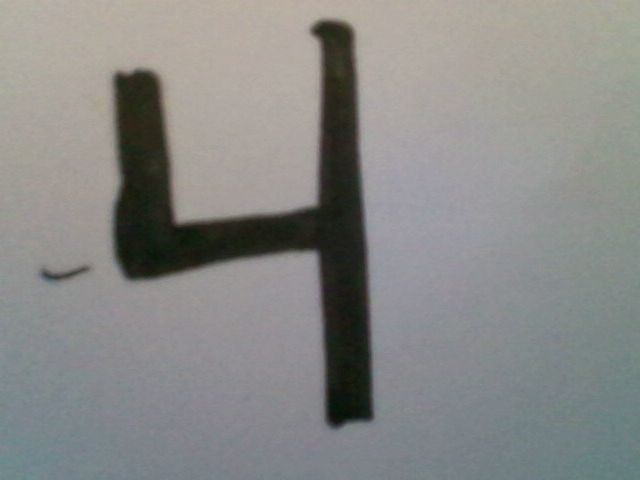

Predicted: [4]


In [ ]:

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  #cv2로 이미지를 읽었습니다. IMREAD_GRAYSCALE를 사용하여 gray색상으로 바꿔줍니다.
  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) 
  
  # gray 색상으로 바꿧다고 해도 A4용지는 흰색, 글씨는 검은색이기 때문에 인식이 어렵습니다.
  # threshhold를 사용하여 train data처럼 글씨를 흰색, a4용지를 검은색으로 바꿔줍니다.
  ret, img = cv2.threshold(img,90,255,cv2.THRESH_BINARY_INV) 
  
  # 캠의 이미지크기와 학습용 이미지의 크기가 달라 사이즈를 보정해줍니다.
  img = cv2.resize(img,(28,28))
  cv2_imshow(img)
  img = img.reshape((-1,28,28,1))

  x = np.array(img)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  print('Predicted:', np.argmax(preds, axis=-1))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

:단계3은 20장의 이미지를 첨부하면 코랩에서 렉이 걸려 따로 첨부합니다.

# **부가 1**

In [ ]:
from keras import backend as K
# 모델의 check 층의 특성 맵 가져옵니다.
last_conv_layer = model.get_layer('check')

In [ ]:
# 예측 벡터의 예측숫자 항목을 five에 저장합니다.
five = model.output[:, np.argmax(preds[0])]

In [ ]:
tf.compat.v1.disable_eager_execution()
# check의 특성 맵 출력에 대한 '예측숫자' 클래스의 그래디언트를 구합니다.
grads = K.gradients(five, last_conv_layer.output)[0]

In [ ]:
# 특성 맵 채널별 그래디언트 평균 값이 담긴 (64,) 크기의 벡터를 구합니다.
pooled_grads = K.mean(grads, axis=(0,1,2))

In [ ]:
# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 check 특성 맵 출력을 구합니다.
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

In [ ]:
# 예측숫자가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다.
pooled_grads_value, conv_layer_output_value = iterate([x])

In [ ]:
# "예측숫자" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다.
for i in range(64):
  conv_layer_output_value[:,:,i]*=pooled_grads_value[i]

In [ ]:
# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다.
heatmap = np.mean(conv_layer_output_value, axis=-1)

(10, 10)


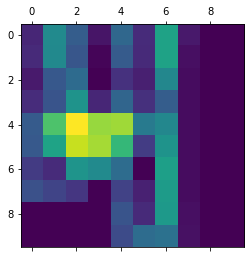

In [ ]:
#시각화를 위해 히트맵을 0과 1 사이로 정규화를 해줍니다.
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
print(heatmap.shape)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
#OpenCV를 사용해 앞에서 얻은 히트맵에 원본 이미지를 겹친 이미지 만듭니다.
import cv2

# cv2 모듈을 사용해 원본 이미지를 로드합니다.
img = cv2.imread(filename)

# heatmap을 원본 이미지 크기에 맞게 변경합니다.
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다.
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다.
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다.
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다.
cv2.imwrite('./number_cam.jpg', superimposed_img)

True

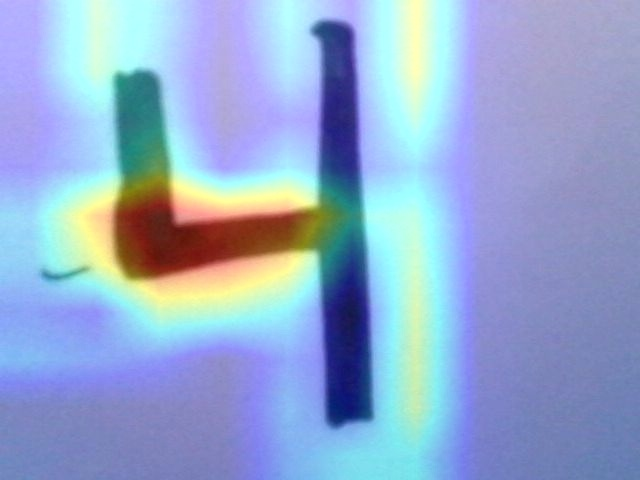

In [ ]:
from IPython.display import Image
Image(filename='./number_cam.jpg')